In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
from utils import plt_layer , load_coffee_data , plot_output_neuron_3D , plt_roast

2025-07-26 13:06:37.415934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 13:06:37.422694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 13:06:37.439430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753515397.465473   41953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753515397.473165   41953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753515397.497250   41953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## DataSet

In [2]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


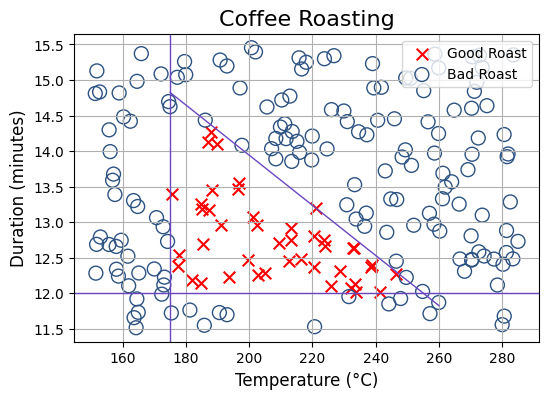

In [3]:
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data will proceed more quickly if the data is normalized.
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- Normalization(axis=-1): tells TensorFlow to normalize each feature column separately
- .adapt(X): learns the average and spread of your training data
- norm_l(X): actually transforms the data (makes mean 0, std 1)

It is important to apply normalization to any future data that utilizes the learned model.

In [4]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


2025-07-26 13:06:40.418160: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [5]:
Xt = np.tile(Xn , (1000,1))
Yt = np.tile(Y , (1000,1))
print(Xt.shape , Yt.shape)

# np.tile(array, (A, B)) means:
# Repeat the array A times vertically (rows)
# Repeat the array B times horizontally (columns)

# So:
# (1000, 1) means:
#   Repeat the rows 1000 times
#   Keep the columns as-is


(200000, 2) (200000, 1)


## Tensorflow Model

In [6]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [9]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

# .get_weights() gives both:
# Weight matrix
# Bias vector

W1(2, 3):
 [[-0.36453533  0.4901482  -0.3843122 ]
 [-0.61697507 -0.28296345 -0.4930653 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.49447083]
 [-0.7572069 ]
 [-0.685961  ]] 
b2(1,): [0.]


- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [10]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2570
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1311
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1157
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0335
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0167
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0111
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0078
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0056
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0040
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0029


#### Updated Weights
After fitting, the weights have been updated: 

In [11]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-17.43011     -0.02566964 -10.618847  ]
 [-14.635091    -8.593008    -0.1875318 ]] 
b1: [ -2.606668 -10.740268 -11.617774]
W2:
 [[ 34.027683]
 [-43.46465 ]
 [-47.82134 ]] 
b2: [-9.162569]


In [12]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
predictions = 
 [[9.6163064e-01]
 [1.0138416e-04]]


### Epochs and batchesI
n model training, an epoch means one full pass through the entire dataset. So, when the output shows Epoch 1/10, it means the model is currently in the first of 10 total passes. Since training on the full dataset at once is inefficient, it is divided into smaller chunks called batches—with a default batch size of 32 in TensorFlow. For a dataset of 200,000 examples, this results in 6250 batches per epoch. During training, the output 6250/6250 [...] shows the progress of batch processing within that epoch, and the loss at the end tells how well the model is learning at that stage.

To convert the probabilities to a decision, we apply a threshold:

In [13]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


To understand how each unit in the neural network contributes to the coffee roasting decision, we examine the output of each neuron for different values of the input features: duration and temperature. Each unit uses a logistic (sigmoid) function, which produces outputs between 0 and 1. By plotting these outputs across a range of inputs, we can visualize how each neuron responds. The shading in the graph represents the output value—darker areas indicate outputs closer to 0, while lighter areas represent values closer to 1. This helps us see what kind of input patterns each unit has learned to detect.

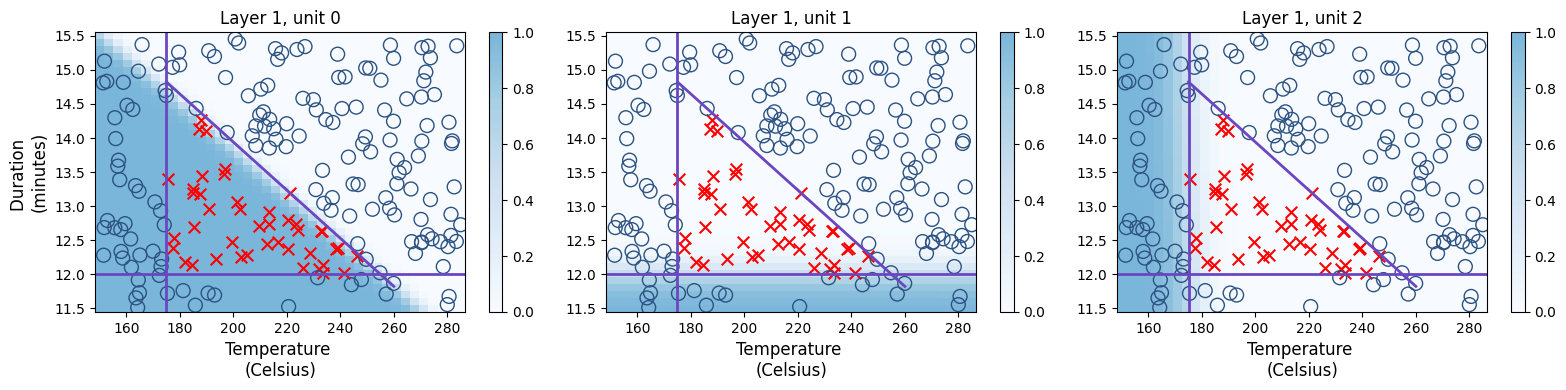

In [14]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)


The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

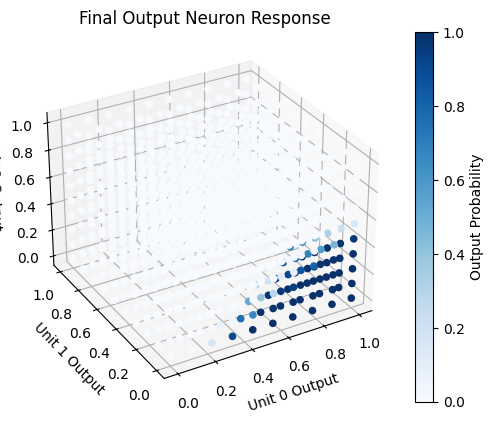

In [15]:
plot_output_neuron_3D(W2, b2)


The 3D plot shows how the final layer of the neural network works. Its inputs are the three outputs from the first layer, which are sigmoid values between 0 and 1. The plot checks all possible combinations of these three values and shows how the final output changes. In the graph, dark blue areas mean the model predicts a high chance of a good roast, while light blue areas mean a low chance (bad roast). So, the model gives higher output (bad roast) when the three inputs are large, and lower output (good roast) when the three inputs are small. This helps us see how the network makes its decision based on the hidden layer outputs.